In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## SASTRAWI EXMPL CODE

In [2]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()
sentence = 'Perekonomian Indonesia sedang dalam pertumbuhan/yang membanggakan'
stemmer.stem(sentence)

'ekonomi indonesia sedang dalam tumbuh yang bangga'

In [3]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
kalimat = 'Dengan Menggunakan Python dan Library Sastrawi saya dapat melakukan proses Stopword Removal'
swdel = StopWordRemoverFactory().create_stop_word_remover()
swdel.remove(kalimat)

'Dengan Menggunakan Python Library Sastrawi dapat melakukan proses Stopword Removal'

## TYPO CORRECTION
from http://www.yasirblog.com/2017/07/spell-checker-pengecekan-ejaan-untuk-deteksi-perbaikan-typo-bahasa-indonesia.html

In [4]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('katadasar.txt').read()))

def P(word, N=sum(WORDS.values())): 
    # "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    # "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    # "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    # "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    # "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)] # [('', 'kemarin'), ('k', 'emarin'), ('ke', 'marin'), dst]
    deletes    = [L + R[1:]               for L, R in splits if R] # ['emarin', 'kmarin', 'kearin', dst]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1] # ['ekmarin', 'kmearin', 'keamrin', dst]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters] # ['aemarin', 'bemarin', 'cemarin', dst]
    inserts    = [L + c + R               for L, R in splits for c in letters] # ['akemarin', 'bkemarin', 'ckemarin', dst]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    # "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
#check typo dalam kalimat
def checktypo(string):
    string = str(string)
    listword = string.split()
    index=0
    for word in string.split():
        listword[index]=correction(word)
        index = index+1
    newstr = ' '.join(word for word in listword)
    return (newstr)

kata = 'mkan'
print('kata typo : ', kata)
print('koreksi : ', correction(kata))

kata typo :  mkan
koreksi :  akan


In [5]:
checktypo('karna orang lebih suka menyumbang')

'karena orang lebih suka menyumbang'

### Try KBBI

In [6]:
from kbbi import KBBI
string = 'asdf'
try:
    print(KBBI(string))
except:
    print('not in kbbi')

not in kbbi


### START DATA EXPLORATION

In [7]:
data=pd.read_csv('UKARA DATA A/Data A/data_train_A.csv')
print(len(data))
print(data.groupby(data['LABEL']).count())
data.head()

268
       RES_ID  RESPONSE
LABEL                  
0          77        77
1         191       191


,RES_ID,RESPONSE,LABEL
0,TRA1,intetraksi/beradaptasi terhadap lingkungan yan...,1
1,TRA2,seperti jatuhnya meteor tsunami gempa bumi,0
2,TRA3,hanya tuhan yang tahu tantangan nya itu apaan,0
3,TRA4,mereka akan sulit beradaptasi,1
4,TRA5,"Tempat tinggal, ekonomi, dan pekerjaan",1


In [8]:
data.dtypes

RES_ID      object
RESPONSE    object
LABEL        int64
dtype: object

Text(0.5, 1.0, 'count label')

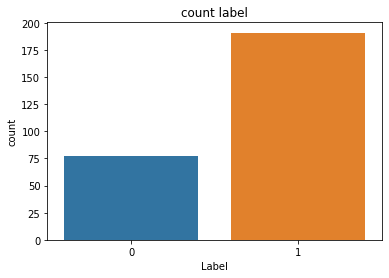

In [9]:
sns.countplot(data['LABEL'])
plt.xlabel('Label')
plt.title('count label')

There are 23645 words in the combination of all review.


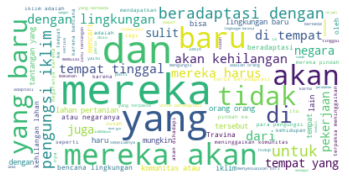

In [10]:
text = " ".join(review for review in data.RESPONSE)
print ("There are {} words in the combination of all review.".format(len(text)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
from collections import Counter
cnt = Counter()
for text in data["RESPONSE"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('yang', 178),
 ('mereka', 167),
 ('akan', 133),
 ('tempat', 94),
 ('dan', 91),
 ('baru', 88),
 ('dengan', 80),
 ('lingkungan', 62),
 ('di', 58),
 ('beradaptasi', 55)]

## PREP DATA

In [12]:
data['processed'] = data['RESPONSE'].str.lower()
data.head()

,RES_ID,RESPONSE,LABEL,processed
0,TRA1,intetraksi/beradaptasi terhadap lingkungan yan...,1,intetraksi/beradaptasi terhadap lingkungan yan...
1,TRA2,seperti jatuhnya meteor tsunami gempa bumi,0,seperti jatuhnya meteor tsunami gempa bumi
2,TRA3,hanya tuhan yang tahu tantangan nya itu apaan,0,hanya tuhan yang tahu tantangan nya itu apaan
3,TRA4,mereka akan sulit beradaptasi,1,mereka akan sulit beradaptasi
4,TRA5,"Tempat tinggal, ekonomi, dan pekerjaan",1,"tempat tinggal, ekonomi, dan pekerjaan"


In [13]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
swdel = StopWordRemoverFactory().create_stop_word_remover()

#insert typos correction here
tmp = 0 #row index
for row in data['processed']:
    data['processed'][tmp] = checktypo(row)
    tmp = tmp+1

tmp = 0 #row index
for row in data['processed']:
    data['processed'][tmp] = stemmer.stem(row)
    tmp = tmp+1
    
tmp = 0 #row index
for row in data['processed']:
    data['processed'][tmp] = swdel.remove(row)
    tmp = tmp+1
    
data.head()

C:\Users\iykmuham0008\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\iykmuham0008\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\iykmuham0008\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,RES_ID,RESPONSE,LABEL,processed
0,TRA1,intetraksi/beradaptasi terhadap lingkungan yan...,1,intetraksi adaptasi hadap lingkung buang baru
1,TRA2,seperti jatuhnya meteor tsunami gempa bumi,0,jatuh meteor tsunami gempa bumi
2,TRA3,hanya tuhan yang tahu tantangan nya itu apaan,0,tuhan buang tahu tantang nya akan
3,TRA4,mereka akan sulit beradaptasi,1,akan sulit adaptasi
4,TRA5,"Tempat tinggal, ekonomi, dan pekerjaan",1,tempat tinggal ekonomi kerja


In [14]:
with pd.option_context('display.max_rows', 999,'display.max_colwidth', 999):
    print(data['processed'].head())
    print(data['processed'].tail())
    #print(data['processed'])

0    intetraksi adaptasi hadap lingkung buang baru
1                  jatuh meteor tsunami gempa bumi
2                tuhan buang tahu tantang nya akan
3                              akan sulit adaptasi
4                     tempat tinggal ekonomi kerja
Name: processed, dtype: object
263                                                                  harus ajar adaptasi lingkung buang baru
264    salah satu tantang buang hadap ungsi iklim sulit baur cari kerja baru laku langsung hidup tempat baru
265                                        hadap lingkung buang mungkin akan perlu waktu buang lama adaptasi
266                          akan baur depan orang baru usaha terima budaya baru cari mampu kerja buang beda
267                                                                                      cari tempat tinggal
Name: processed, dtype: object


In [15]:
from collections import Counter
cnt = Counter()
for text in data["processed"].values:
    for word in text.split():
        cnt[word] += 1
        
print(cnt.most_common(999))

[('buang', 189), ('baru', 125), ('tempat', 113), ('depan', 95), ('akan', 85), ('lingkung', 74), ('adaptasi', 70), ('tinggal', 60), ('iklim', 58), ('ungsi', 52), ('hilang', 46), ('negara', 40), ('mereka', 39), ('harus', 34), ('kerja', 33), ('hadap', 32), ('orang', 32), ('tantang', 27), ('pindah', 26), ('sulit', 25), ('tani', 25), ('jadi', 23), ('bencana', 23), ('mungkin', 21), ('sesuai', 20), ('hidup', 20), ('beda', 19), ('di', 18), ('komunitas', 18), ('biasa', 18), ('cari', 18), ('travina', 17), ('paksa', 16), ('lama', 15), ('susah', 15), ('sebut', 14), ('diri', 14), ('tidak', 13), ('satu', 13), ('warga', 13), ('rasa', 11), ('perlu', 11), ('nya', 10), ('butuh', 10), ('milik', 10), ('mulai', 10), ('kurang', 9), ('dulu', 8), ('laku', 8), ('pakai', 8), ('juga', 8), ('daerah', 8), ('lebih', 8), ('rumah', 7), ('nyaman', 7), ('bisa', 7), ('budaya', 7), ('salah', 6), ('sangat', 6), ('ubah', 6), ('besar', 6), ('dari', 6), ('baik', 6), ('belum', 6), ('dapat', 6), ('hari', 6), ('rela', 5), ('sem

## MODELING without processing

In [17]:
from sklearn.model_selection import train_test_split
xtr,xts,ytr,yts=train_test_split(data['RESPONSE'].apply(lambda x:x.lower()),data['LABEL'],
    stratify=data['LABEL'],
    test_size=0.2, 
    random_state=420)
print(xtr.shape)
print(xts.shape)

(214,)
(54,)


In [18]:
test=pd.read_csv('UKARA DATA A/Data A/data_dev_A.csv')
#print(np.array(test['RESPONSE']).reshape(len(test['RESPONSE']),1))

In [19]:

multinomialPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',MultinomialNB())
])
multinomialPipeline.fit(xtr,ytr)
multinomialPrediksiTrain = multinomialPipeline.predict(xtr)
multinomialPrediksi = multinomialPipeline.predict(xts)
multinomialPrediksiDev = multinomialPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [20]:
complementPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',ComplementNB())
])
complementPipeline.fit(xtr,ytr)
complementPrediksiTrain = complementPipeline.predict(xtr)
complementPrediksi = complementPipeline.predict(xts)
complementPrediksiDev = complementPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [21]:
adaboostPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',AdaBoostClassifier())
])
adaboostPipeline.fit(xtr,ytr)
adaboostPrediksiTrain = adaboostPipeline.predict(xtr)
adaboostPrediksi = adaboostPipeline.predict(xts)
adaboostPrediksiDev = adaboostPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [22]:
print(multinomialPrediksi)
print("----------------------------------------------------")
print(complementPrediksi)

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------
[1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


In [23]:
print('Dengan metode MultinomialNB, diperoleh: ')
print(classification_report(yts,multinomialPrediksi))
print('Skor f1:',f1_score(yts,multinomialPrediksi))
print(confusion_matrix(yts,multinomialPrediksi))

Dengan metode MultinomialNB, diperoleh: 
              precision    recall  f1-score   support

           0       1.00      0.19      0.32        16
           1       0.75      1.00      0.85        38

    accuracy                           0.76        54
   macro avg       0.87      0.59      0.58        54
weighted avg       0.82      0.76      0.69        54

Skor f1: 0.8539325842696629
[[ 3 13]
 [ 0 38]]


In [24]:
print('Dengan metode ComplementNB, diperoleh: ')
# print(classification_report(ytr,complementPrediksiTrain))
print(classification_report(yts,complementPrediksi))
print('Skor f1:',f1_score(yts,complementPrediksi))
print(confusion_matrix(yts,complementPrediksi))

Dengan metode ComplementNB, diperoleh: 
              precision    recall  f1-score   support

           0       0.89      0.50      0.64        16
           1       0.82      0.97      0.89        38

    accuracy                           0.83        54
   macro avg       0.86      0.74      0.77        54
weighted avg       0.84      0.83      0.82        54

Skor f1: 0.891566265060241
[[ 8  8]
 [ 1 37]]


In [25]:
print('Dengan metode AdaBoostClassifier, diperoleh: ')
# print(classification_report(ytr,adaboostPrediksiTrain))
print(classification_report(yts,adaboostPrediksi))
print('Skor f1:',f1_score(yts,adaboostPrediksi))
print(confusion_matrix(yts,complementPrediksi))

Dengan metode AdaBoostClassifier, diperoleh: 
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        16
           1       0.86      0.82      0.84        38

    accuracy                           0.78        54
   macro avg       0.74      0.75      0.74        54
weighted avg       0.79      0.78      0.78        54

Skor f1: 0.8378378378378377
[[ 8  8]
 [ 1 37]]


## MODELING with processing

In [26]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(data['processed'].apply(lambda x:x.lower()),data['LABEL'],
    stratify=data['LABEL'],
    test_size=0.2, 
    random_state=420)
print(xtrain.shape)
print(xtest.shape)

(214,)
(54,)


In [27]:

multinomialPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',MultinomialNB())
])
multinomialPipeline.fit(xtrain,ytrain)
multinomialPrediksiTrain = multinomialPipeline.predict(xtrain)
multinomialPrediksi = multinomialPipeline.predict(xtest)
#multinomialPrediksiDev = multinomialPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [28]:
complementPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',ComplementNB())
])
complementPipeline.fit(xtrain,ytrain)
complementPrediksiTrain = complementPipeline.predict(xtrain)
complementPrediksi = complementPipeline.predict(xtest)
#complementPrediksiDev = complementPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [29]:
adaboostPipeline = Pipeline([
    ('cv',CountVectorizer()),
    ('classifier',AdaBoostClassifier())
])
adaboostPipeline.fit(xtrain,ytrain)
adaboostPrediksiTrain = adaboostPipeline.predict(xtrain)
adaboostPrediksi = adaboostPipeline.predict(xtest)
#adaboostPrediksiDev = adaboostPipeline.predict(test['RESPONSE'].apply(lambda x:x.lower()))

In [30]:
print(multinomialPrediksi)
print("----------------------------------------------------")
print(complementPrediksi)

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
----------------------------------------------------
[1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1]


In [31]:
print(' MultinomialNB + wordstop + stemming, diperoleh: ')
print(classification_report(ytest,multinomialPrediksi))
print('Skor f1:',f1_score(ytest,multinomialPrediksi))
print(confusion_matrix(ytest,multinomialPrediksi))

 MultinomialNB + wordstop + stemming, diperoleh: 
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        16
           1       0.76      1.00      0.86        38

    accuracy                           0.78        54
   macro avg       0.88      0.62      0.63        54
weighted avg       0.83      0.78      0.73        54

Skor f1: 0.8636363636363636
[[ 4 12]
 [ 0 38]]


In [32]:
print('ComplementNB + wordstop + stemming, diperoleh: ')
# print(classification_report(ytr,complementPrediksiTrain))
print(classification_report(ytest,complementPrediksi))
print('Skor f1:',f1_score(ytest,complementPrediksi))
print(confusion_matrix(ytest,complementPrediksi))

ComplementNB + wordstop + stemming, diperoleh: 
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           1       0.88      0.95      0.91        38

    accuracy                           0.87        54
   macro avg       0.86      0.82      0.84        54
weighted avg       0.87      0.87      0.87        54

Skor f1: 0.9113924050632912
[[11  5]
 [ 2 36]]


In [33]:
print(' AdaBoostClassifier + wordstop + stemming, diperoleh: ')
# print(classification_report(ytr,adaboostPrediksiTrain))
print(classification_report(ytest,adaboostPrediksi))
print('Skor f1:',f1_score(ytest,adaboostPrediksi))
print(confusion_matrix(ytest,complementPrediksi))

 AdaBoostClassifier + wordstop + stemming, diperoleh: 
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.85      0.87      0.86        38

    accuracy                           0.80        54
   macro avg       0.76      0.75      0.75        54
weighted avg       0.79      0.80      0.79        54

Skor f1: 0.8571428571428572
[[11  5]
 [ 2 36]]
